In [4]:
import os
from ete3 import Tree
import matplotlib.pyplot as plt
import tqdist


#max_rf = 34

def rf_distance(t1, t2):
    rf, max_rf, common_leaves, parts_t1, parts_t2,discard_t1, discart_t2 = t1.robinson_foulds(t2, unrooted_trees = True)
    return rf

def calculate_dm():
    distance_matrix = [[0.0 for _ in range(1000)] for __ in range(1000)]
    trees = [None for _ in range(1000)]
    d = "output/"
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file() or not entry.name.endswith("bestTree"):
                continue
            digits = entry.name.split('.')[0]
            try:
                idx = int(digits) -1
            except:
                continue
            trees[idx] = Tree(os.path.join(d, entry.name))
    
    for i in range(1000):
        for j in range(i, 1000):
            rfd = rf_distance(trees[i], trees[j])
            distance_matrix[i][j] = rfd
            distance_matrix[j][i] = rfd
            
    with open("temp/distance.matrix", "w+") as dm_file:
        for row in distance_matrix:
            dm_file.write(",".join([str(el) for el in row]) + "\n")
            
    return distance_matrix


def calculate_quartet_dm():
    distance_matrix = [[0.0 for _ in range(1000)] for __ in range(1000)]
    tree_names = ["" for _ in range(1000)]
    d = "output/"
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file() or not entry.name.endswith("bestTree"):
                continue
            digits = entry.name.split('.')[0]
            try:
                idx = int(digits) -1
            except:
                continue
            tree_names[idx] = os.path.join(d, entry.name)
    
    for i in range(1000):
        for j in range(i, 1000):
            qd = quartet_dist(tree_names[i], tree_names[j])
            distance_matrix[i][j] = qd
            distance_matrix[j][i] = qd
            
    with open("temp/quartet_distance.matrix", "w+") as dm_file:
        for row in distance_matrix:
            dm_file.write(",".join([str(el) for el in row]) + "\n")
            
    return distance_matrix

def calculate_dist_to_fixed(name):
    d_file = open("temp/" + name + "_dist.matrix", "w+")
    d = "output/"
    full_tree = Tree(os.path.join("ref_trees", name + ".tree"))
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file() or not entry.name.endswith("bestTree"):
                continue
            digits = entry.name.split('.')[0]
            try:
                idx = int(digits) -1
            except:
                continue
            t = Tree(os.path.join(d, entry.name))
            d_file.write(str(rf_distance(t, full_tree)) + "\n")
            
            
def calculate_quartet_dist_to_fixed(name):
    print("yes")
    d_file = open("temp/" + name + "_quartet_dist.matrix", "w+")
    d = "output/"
    full_tree_name = os.path.join("ref_trees", name + ".tree")
    print("ok")
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file() or not entry.name.endswith("bestTree"):
                continue
            digits = entry.name.split('.')[0]
            try:
                idx = int(digits) -1
            except:
                continue
            print("HI")
            #q_dist = tqdist.quartet_distance(os.path.join(d, entry.name), full_tree_name)
            #print(q_dist)
            #d_file.write(str(q_dist) + "\n")


calculate_quartet_dist_to_fixed("full")
calculate_quartet_dist_to_fixed("glottolog")
#calculate_quartet_dm()
                
                
                

yes
ok
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI


In [2]:
def read_dm(metric):
    if metric == "RF":
        f_name = "temp/distance.matrix"
    elif metric == "quartet":
        f_name = "temp/quartet_distance.matrix"
    else:
        print(metric + " - this metric is not supported")
    dm = []
    for row in open(f_name, "r").read().split("\n")[:-1]:
        dm.append([int(val) for val in row.split(',')])
    return dm

def to_relative(dm):
    max_rf = 34
    rel_dm = []
    for row in dm:
        rel_dm.append([val/34 for val in row])
    return rel_dm



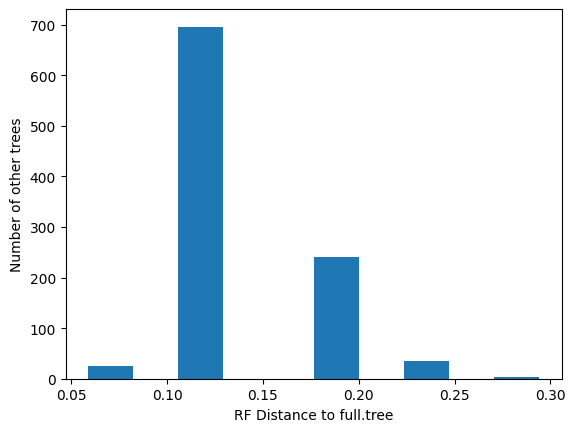

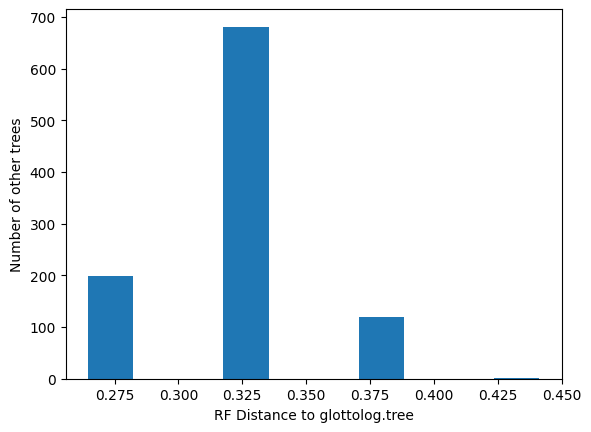

In [6]:
def fixed_analysis(name, metric):
    if metric == "RF":
        f_name = "temp/" + name + "_dist.matrix"
    elif metric == "quartet":
        f_name = "temp/" + name + "quartet_dist.matrix"
    else:
        print(metric + " - this metric is not supported")
    d = [float(val) for val in open(f_name, "r").read().split("\n")[:-1]]
    if metric == "RF":
        d = [val/34 for val in d]
    plt.xlabel(metric+" Distance to " + name + ".tree")
    plt.ylabel("Number of other trees")
    plt.hist(d)
    plt.show()
    
fixed_analysis("full", "RF")
fixed_analysis("glottolog", "RF")

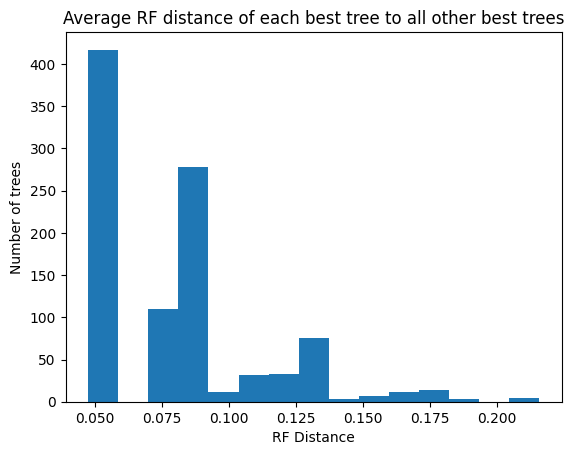

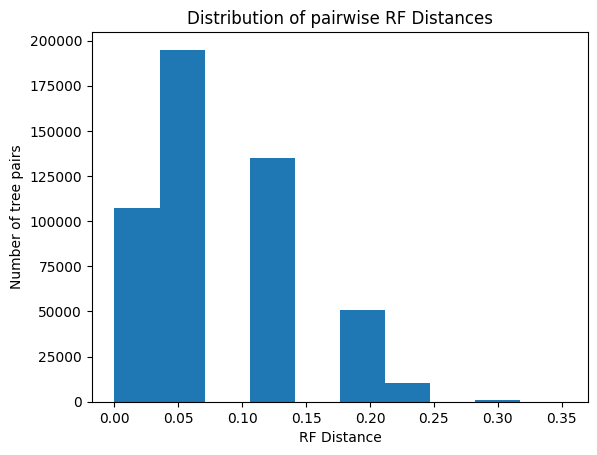

In [5]:
def matrix_analysis(metric):
    dm = read_dm(metric)
    if metric == "RF":
        dm = to_relative(dm)
    upper_triangle = [dm[i][j] for i in range(1000) for j in range(i+1, 1000)]
    avgs = [sum(dm[i]) / 999 for i in range(1000)]
    avg = sum(upper_triangle) / len(upper_triangle)
    #print(avg)
    plt.title("Average " + metric + " distance of each best tree to all other best trees")
    plt.xlabel(metric + " Distance")
    plt.ylabel("Number of trees")
    plt.hist(avgs, bins=15)
    plt.show()

    plt.title("Distribution of pairwise " + metric + " Distances")
    plt.xlabel(metric + " Distance")
    plt.ylabel("Number of tree pairs")
    plt.hist(upper_triangle, bins=10)
    plt.show()
    
matrix_analysis("RF")